<a href="https://colab.research.google.com/github/GenaroHacker/creating_chord_collection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
%%capture
#@title Set Up
!git clone https://github.com/GenaroHacker/write_imports.git
from write_imports.write_imports import write_imports

!git clone https://github.com/GenaroHacker/creating_chord_collection.git


from creating_chord_collection.collection.resources.scales import scales
from creating_chord_collection.collection.resources.transposable_figures import transposable_figures



In [122]:



# Delete this line to see the new imports
%%capture



#@title Import Statements
#Modules: ['write_imports', 'creating_chord_collection']



from write_imports.write_imports import write_imports

from write_imports.LearningPython.BasicExamples.intro_functions import print_hello_world


from creating_chord_collection.collection.chord import GuitarChord

from creating_chord_collection.collection.collection import ChordCollection







print(write_imports([]))






In [123]:
# @title Chord


# Example
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
print(chord)
print("String Frequencies:", chord.calculate_frequencies())
print("Is Open Chord:", chord.is_open())
chord.transpose(0)
print(chord.get_notes(include_strings=True))
print(chord.get_notes())

# Validate the chord against the C major scale
ionian_scale = scales["ionian"]
tonic = "C"
is_chord_in_scale = chord.validate_against_scale(tonic, ionian_scale)
print(f"Chord fits in C major scale: {is_chord_in_scale}")


('E', 'm', finger_ascending=[0, 0, 0, 2, 2, 0], starting_fret=1)
String Frequencies: {1: 329.63, 2: 246.94, 3: 196.0, 4: 164.81110255326524, 5: 123.47082531403103, 6: 82.41}
Is Open Chord: True
{1: 'E', 2: 'B', 3: 'G', 4: 'E', 5: 'B', 6: 'E'}
['E', 'B', 'G']
Chord fits in C major scale: True


In [124]:
# @title Abstract Builders
from PIL import Image, ImageDraw, ImageFont

class AbstractBuilder:
    def __init__(self):
        self.image_size = None
        self.fret_edges = []
        self.frets_starting_points = []
        self.string_edges = []
        self.strings_starting_points = []
        self.notes_coordenates = None
        self.name_coordenate = None
        self.font = "/content/creating_chord_collection/times.ttf"
        self.font_size = 50
        self.line_thickness = 3
        self.is_horizontal = None
        self.root = None
        self.starting_fret = None
        self.chord_type = None
        self.finger_ascending = None
        self.scale_name = None
        self.scale = None

    def draw_boundaries(self):
        self.image = Image.new('RGB', self.image_size, 'white')
        self.draw = ImageDraw.Draw(self.image)

    def draw_frets(self):
        for fret_start in self.frets_starting_points:
            start_point = (fret_start, self.fret_edges[0]) if self.is_horizontal else (self.fret_edges[0], fret_start)
            end_point = (fret_start, self.fret_edges[1]) if self.is_horizontal else (self.fret_edges[1], fret_start)
            self.draw.line(start_point + end_point, fill='black', width=self.line_thickness)

    def draw_strings(self):
        custom_grey = (210, 210, 210)

        for index, string_start in enumerate(self.strings_starting_points):
            color = custom_grey if self.finger_ascending and self.finger_ascending[index] is None else 'black'
            start_point = (self.string_edges[0], string_start) if self.is_horizontal else (string_start, self.string_edges[0])
            end_point = (self.string_edges[1], string_start) if self.is_horizontal else (string_start, self.string_edges[1])
            self.draw.line(start_point + end_point, fill=color, width=self.line_thickness - 1)


    def write_starting_fret(self):
        raise NotImplementedError


    def write_name(self, name):
        try:
            font = ImageFont.truetype(self.font, self.font_size)
        except IOError:
            font = ImageFont.load_default()
        self.draw.text(self.name_coordenate, name, fill='black', font=font)




    def draw_notes(self, notes_style):
        raise NotImplementedError

    def get_result(self):
        return self.image

class ShortAbstractBuilder(AbstractBuilder):
    def __init__(self):
        super().__init__()
        self.image_size = (351, 351)
        self.is_horizontal = False
        self.fret_edges = [78, 273]
        self.frets_starting_points = [107, 157, 207, 257, 307]
        self.string_edges = [107, 307]
        self.strings_starting_points = [273, 234, 195, 156, 117, 78]
        self.notes_coordenates = {"strings": [273, 234, 195, 156, 117, 78], "frets": [82, 132, 182, 232, 282]}
        self.name_coordenate = (145, 10)

class LongAbstractBuilder(AbstractBuilder):
    def __init__(self):
        super().__init__()
        self.image_size = (717, 362)
        self.is_horizontal = True
        self.fret_edges = [82, 277]
        self.frets_starting_points = [67, 117, 167, 217, 267, 317, 367, 417, 467, 517, 567, 617, 667]
        self.string_edges = [67, 667]
        self.strings_starting_points = [82, 121, 160, 199, 238, 277]
        self.notes_coordenates = {"strings": [82, 121, 160, 199, 238, 277], "frets": [42, 92, 142, 192, 242, 292, 342, 392, 442, 492, 542, 592, 642]}
        self.name_coordenate = (330, 7)


In [125]:
# @title Concrete Builders


class ShortChordBuilder(ShortAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = False

class ShortScaleBuilder(ShortAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = True

class LongChordBuilder(LongAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = False

class LongScaleBuilder(LongAbstractBuilder):
    def __init__(self):
        super().__init__()
        self.is_scale = True


In [126]:
# @title Director
class Director:
    def __init__(self, builder):
        self._builder = builder

    def build_chord(self, chord):
        self._builder.draw_boundaries()
        self._builder.root = chord.root
        self._builder.chord_type = chord.chord_type
        self._builder.finger_ascending = chord.finger_ascending
        self._builder.starting_fret = chord.starting_fret
        self._builder.draw_frets()
        self._builder.draw_strings()
        chord_name = chord.root + chord.chord_type
        self._builder.write_name(chord_name)

    def build_scale(self, scale):
        self._builder.draw_boundaries()
        self._builder.root = scale.root
        self._builder.scale_name = scale.name
        self._builder.starting_fret = scale.starting_fret
        self._builder.scale = scale
        # Additional methods for drawing scale might be added here


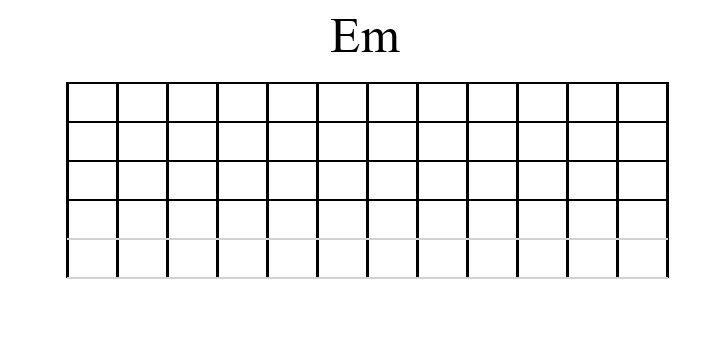

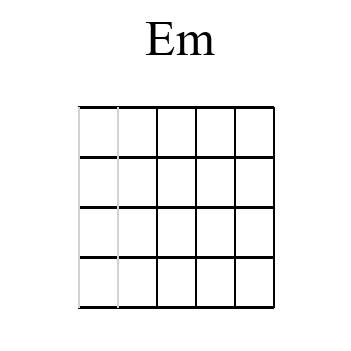

In [127]:
# @title Main Execution
# Example usage for a chord
chord = GuitarChord('E', 'm', transposable_figures, finger_ascending=[0, 0, 0, 2, None, None], starting_fret=1)
builder = LongScaleBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result
result_image = builder.get_result()

# Display the image in the Jupyter notebook
display(result_image)






builder = ShortChordBuilder()
director = Director(builder)
director.build_chord(chord)

# Get the final image result
result_image = builder.get_result()

# Display the image in the Jupyter notebook
display(result_image)
